In [1]:
# Install required packages
!pip install -q imagehash
!pip install -q efficientnet
!pip install -q tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.3 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement tensorflow-addons (from versions: none)
ERROR: No matching distribution found for tensorflow-addons


In [2]:
!pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-lw84f0kx
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/classification_models.git /tmp/pip-req-build-lw84f0kx
  Resolved https://github.com/qubvel/classification_models.git to commit a0f006e05485a34ccf871c421279864b0ccd220b
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
  Created wheel for image_classifiers: filename=image_classifiers-1.0.0-py3-none-any.whl size=20031 sha256=694949d3b0706fda747957f6f387e7e252ca2612039bdf028972f44fc3dcc8e3
  Stored in directory: /tmp/pip-ephem-wheel-cache-tgod5yxc/wheels/85/3d/0c/2f2aa46015b8eeab37b900c17a82b4ad61595376201f1e24b5
Successfully built image_classifiers


In [3]:
import os
import shutil
import hashlib
import imagehash
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from pathlib import Path
from tensorflow import keras
from tensorflow.keras import layers, regularizers, mixed_precision

from classification_models.tfkeras import Classifiers
ResNet34, preprocess_input_resnet34 = Classifiers.get('resnet34')

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,
    CSVLogger, LearningRateScheduler
)
from matplotlib import pyplot as plt
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc, precision_recall_curve,
    f1_score, classification_report, roc_auc_score
)
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import logging
import warnings
import json
from datetime import datetime

# Configure logging and warnings
logging.basicConfig(level=logging.WARNING)
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('default')
sns.set_palette("husl")

In [4]:
def setup_gpu_and_reproducibility():
    """Configure GPU and ensure reproducible results"""
    # GPU Configuration
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print(f"✓ {len(gpus)} GPU(s) available and configured")
        except RuntimeError as e:
            print(f"GPU configuration error: {e}")
    else:
        print("⚠ No GPU available, running on CPU")

    # Reproducibility settings
    SEED = 42
    os.environ['PYTHONHASHSEED'] = str(SEED)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    tf.keras.utils.set_random_seed(SEED)
    tf.config.experimental.enable_op_determinism()

    # Mixed precision for faster training
    mixed_precision.set_global_policy("mixed_float16")
    print("✓ Mixed precision enabled")
    print("✓ Reproducibility configured")

    return SEED

SEED = setup_gpu_and_reproducibility()

✓ 1 GPU(s) available and configured
✓ Mixed precision enabled
✓ Reproducibility configured


In [5]:
# Mount Google Drive (if using Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("✓ Google Drive mounted")
except ImportError:
    print("Not running in Colab - skipping Drive mount")

Mounted at /content/drive
✓ Google Drive mounted


In [6]:
# Dataset Configuration
CONFIG = {
    # Paths
    'source_dir': Path('/content/drive/MyDrive/training-setX'),
    'output_base_dir': Path('/content/drive/MyDrive/clean_dataset'),
    'models_dir': Path('/content/drive/MyDrive/wheat_models'),
    'results_dir': Path('/content/drive/MyDrive/wheat_results'),

    # Data splits
    'train_ratio': 0.7,
    'val_ratio': 0.2,
    'test_ratio': 0.1,

    # Image processing
    'img_size': (224, 224),  # Standard size for pre-trained models
    'batch_size': 32,        # Optimized for 3800 images
    'hash_size': 8,
    'min_std_threshold': 10, # Filter out low-variance images

    # Training parameters
    'epochs': 35,
    'initial_lr': 1e-4,
    'patience': 15,
    'min_lr': 1e-7,

    # Model architectures to compare
    'models_to_test': ['ResNet34'],

    # Regularization
    'dropout_rate': 0.3,
    'l2_reg': 1e-4,

    # Random seed
    'random_state': SEED
}

# Create directories
for dir_path in [CONFIG['models_dir'], CONFIG['results_dir']]:
    dir_path.mkdir(parents=True, exist_ok=True)

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration:
  source_dir: /content/drive/MyDrive/training-setX
  output_base_dir: /content/drive/MyDrive/clean_dataset
  models_dir: /content/drive/MyDrive/wheat_models
  results_dir: /content/drive/MyDrive/wheat_results
  train_ratio: 0.7
  val_ratio: 0.2
  test_ratio: 0.1
  img_size: (224, 224)
  batch_size: 32
  hash_size: 8
  min_std_threshold: 10
  epochs: 35
  initial_lr: 0.0001
  patience: 15
  min_lr: 1e-07
  models_to_test: ['ResNet34']
  dropout_rate: 0.3
  l2_reg: 0.0001
  random_state: 42


In [7]:
def get_image_features(image_path, hash_size=8, min_std=10):
    """Extract comprehensive image features for duplicate detection and quality assessment"""
    try:
        # File hash for exact duplicates
        with open(image_path, 'rb') as f:
            file_hash = hashlib.md5(f.read()).hexdigest()

        # Load and analyze image
        img = Image.open(image_path).convert('RGB')
        img_array = np.array(img, dtype=np.float32)

        # Quality checks
        std = img_array.std()
        if std < min_std:
            return None  # Skip low-variance images

        # Perceptual hash for near-duplicates
        perceptual_hash = imagehash.phash(img, hash_size=hash_size)

        # Additional features
        mean_brightness = img_array.mean()
        contrast = img_array.max() - img_array.min()

        return {
            'file_hash': file_hash,
            'perceptual_hash': str(perceptual_hash),
            'std': std,
            'mean_brightness': mean_brightness,
            'contrast': contrast,
            'shape': img.size,
            'path': str(image_path)
        }
    except Exception as e:
        logging.warning(f"Error processing {image_path}: {e}")
        return None

def remove_duplicates(features_list, hamming_threshold=5):
    """Remove exact and near-duplicate images using hash comparison"""
    unique_features = []
    seen_hashes = set()
    perceptual_hashes = []

    print(f"Processing {len(features_list)} images for duplicate removal...")

    for features in features_list:
        # Remove exact duplicates
        if features['file_hash'] in seen_hashes:
            continue

        # Check for near-duplicates
        current_hash = imagehash.hex_to_hash(features['perceptual_hash'])
        is_duplicate = False

        for existing_hash in perceptual_hashes:
            if abs(current_hash - existing_hash) <= hamming_threshold:
                is_duplicate = True
                break

        if not is_duplicate:
            unique_features.append(features)
            seen_hashes.add(features['file_hash'])
            perceptual_hashes.append(current_hash)

    removed = len(features_list) - len(unique_features)
    print(f"✓ Removed {removed} duplicate images")
    return unique_features

def analyze_dataset_distribution(features_list):
    """Analyze and visualize dataset characteristics"""
    df = pd.DataFrame(features_list)

    print("\nDataset Analysis:")
    print(f"Total images: {len(df)}")
    print(f"Classes: {df['class'].value_counts().to_dict()}")
    print(f"Average image std: {df['std'].mean():.2f}")
    print(f"Average brightness: {df['mean_brightness'].mean():.2f}")
    print(f"Average contrast: {df['contrast'].mean():.2f}")

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle('Dataset Quality Analysis', fontsize=16)

    # Class distribution
    df['class'].value_counts().plot(kind='bar', ax=axes[0,0], color=['green', 'orange'])
    axes[0,0].set_title('Class Distribution')
    axes[0,0].set_ylabel('Number of Images')

    # Image quality metrics
    df['std'].hist(bins=30, ax=axes[0,1], alpha=0.7)
    axes[0,1].set_title('Image Standard Deviation')
    axes[0,1].set_xlabel('Standard Deviation')

    df['mean_brightness'].hist(bins=30, ax=axes[1,0], alpha=0.7)
    axes[1,0].set_title('Average Brightness')
    axes[1,0].set_xlabel('Brightness')

    df['contrast'].hist(bins=30, ax=axes[1,1], alpha=0.7)
    axes[1,1].set_title('Image Contrast')
    axes[1,1].set_xlabel('Contrast')

    plt.tight_layout()
    plt.show()

    return df

In [8]:
# Process and analyze dataset
print("Starting dataset processing...")

# Collect image features
all_features = []
processed_count = 0

for class_dir in CONFIG['source_dir'].iterdir():
    if class_dir.is_dir():
        print(f"Processing class: {class_dir.name}")
        class_count = 0

        for img_file in class_dir.iterdir():
            if img_file.suffix.lower() in ['.png', '.jpg', '.jpeg']:
                features = get_image_features(
                    img_file,
                    CONFIG['hash_size'],
                    CONFIG['min_std_threshold']
                )
                if features:
                    features['class'] = class_dir.name
                    features['filename'] = img_file.name
                    all_features.append(features)
                    class_count += 1

                processed_count += 1
                if processed_count % 500 == 0:
                    print(f"  Processed {processed_count} images...")

        print(f"  ✓ {class_count} valid images found in {class_dir.name}")

print(f"\n✓ Initial processing complete: {len(all_features)} valid images")

Starting dataset processing...
Processing class: Ready
  Processed 500 images...
  Processed 1000 images...
  Processed 1500 images...
  ✓ 1900 valid images found in Ready
Processing class: not-Ready
  Processed 2000 images...
  Processed 2500 images...
  Processed 3000 images...
  Processed 3500 images...
  ✓ 1900 valid images found in not-Ready

✓ Initial processing complete: 3800 valid images


Processing 3800 images for duplicate removal...
✓ Removed 38 duplicate images

Dataset Analysis:
Total images: 3762
Classes: {'not-Ready': 1899, 'Ready': 1863}
Average image std: 48.39
Average brightness: 78.20
Average contrast: 251.42


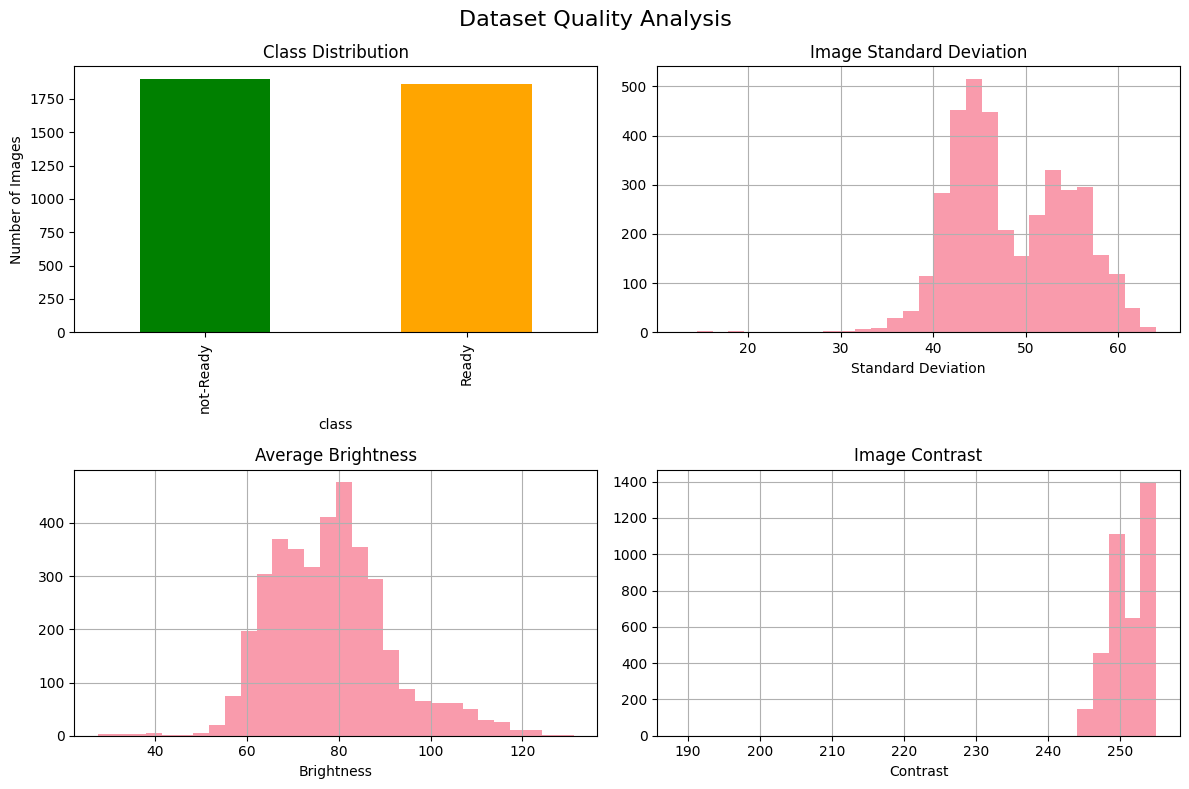

✓ Dataset information saved to /content/drive/MyDrive/wheat_results/dataset_info.json


In [9]:
# Remove duplicates and analyze dataset
clean_features = remove_duplicates(all_features)
dataset_df = analyze_dataset_distribution(clean_features)

# Save cleaned dataset info
dataset_info_path = CONFIG['results_dir'] / 'dataset_info.json'
with open(dataset_info_path, 'w') as f:
    dataset_info = {
        'total_images': len(clean_features),
        'class_distribution': dataset_df['class'].value_counts().to_dict(),
        'avg_std': float(dataset_df['std'].mean()),
        'avg_brightness': float(dataset_df['mean_brightness'].mean()),
        'avg_contrast': float(dataset_df['contrast'].mean()),
        'processing_timestamp': datetime.now().isoformat()
    }
    json.dump(dataset_info, f, indent=2)

print(f"✓ Dataset information saved to {dataset_info_path}")

In [10]:
def create_stratified_splits(dataset_df, config):
    """Create stratified train/val/test splits with group-based splitting to avoid data leakage"""

    # Create groups based on image similarity (using perceptual hash)
    # This helps prevent similar images from appearing in different splits
    dataset_df['group'] = dataset_df.groupby('perceptual_hash').ngroup()

    # First split: separate test set
    splitter1 = GroupShuffleSplit(
        n_splits=1,
        test_size=config['test_ratio'],
        random_state=config['random_state']
    )

    train_val_idx, test_idx = next(splitter1.split(
        dataset_df, dataset_df['class'], dataset_df['group']
    ))

    # Second split: separate train and validation
    train_val_df = dataset_df.iloc[train_val_idx].copy()
    val_size = config['val_ratio'] / (config['train_ratio'] + config['val_ratio'])

    splitter2 = GroupShuffleSplit(
        n_splits=1,
        test_size=val_size,
        random_state=config['random_state']
    )

    train_idx, val_idx = next(splitter2.split(
        train_val_df, train_val_df['class'], train_val_df['group']
    ))

    # Create final splits
    splits = {
        'train': train_val_df.iloc[train_idx].copy(),
        'val': train_val_df.iloc[val_idx].copy(),
        'test': dataset_df.iloc[test_idx].copy()
    }

    # Print split information
    print("\nDataset Splits:")
    for split_name, split_df in splits.items():
        class_counts = split_df['class'].value_counts()
        print(f"{split_name.upper()}:")
        print(f"  Total: {len(split_df)}")
        for class_name, count in class_counts.items():
            percentage = (count / len(split_df)) * 100
            print(f"  {class_name}: {count} ({percentage:.1f}%)")

    return splits

# Create splits
data_splits = create_stratified_splits(dataset_df, CONFIG)

# Save split information
for split_name, split_df in data_splits.items():
    split_path = CONFIG['results_dir'] / f'{split_name}_split.csv'
    split_df.to_csv(split_path, index=False)
    print(f"✓ {split_name} split saved to {split_path}")


Dataset Splits:
TRAIN:
  Total: 2632
  not-Ready: 1352 (51.4%)
  Ready: 1280 (48.6%)
VAL:
  Total: 753
  Ready: 397 (52.7%)
  not-Ready: 356 (47.3%)
TEST:
  Total: 377
  not-Ready: 191 (50.7%)
  Ready: 186 (49.3%)
✓ train split saved to /content/drive/MyDrive/wheat_results/train_split.csv
✓ val split saved to /content/drive/MyDrive/wheat_results/val_split.csv
✓ test split saved to /content/drive/MyDrive/wheat_results/test_split.csv


In [11]:
def create_data_generators(data_splits, config):
    """Create optimized data generators with agriculture-specific augmentations"""

    # Training augmentation - realistic for aerial crop imagery
    train_datagen = keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,          # Small rotations (drone angle variations)
        width_shift_range=0.1,      # Slight position shifts
        height_shift_range=0.1,
        shear_range=0.1,           # Perspective variations
        zoom_range=0.15,           # Altitude variations
        horizontal_flip=True,       # Mirror images
        vertical_flip=True,         # 180° rotations
        brightness_range=[0.8, 1.2], # Lighting conditions
        fill_mode='reflect',
        channel_shift_range=20,     # Color variations
    )

    # Validation/Test - only rescaling
    val_test_datagen = keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255
    )

    def create_temp_directory(split_df, split_name):
        """Create temporary directory structure for ImageDataGenerator"""
        temp_dir = CONFIG['output_base_dir'] / f'temp_{split_name}'
        temp_dir.mkdir(parents=True, exist_ok=True)

        # Create class subdirectories
        for class_name in split_df['class'].unique():
            class_dir = temp_dir / class_name
            class_dir.mkdir(exist_ok=True)

            # Copy images to temporary structure
            class_images = split_df[split_df['class'] == class_name]
            for _, row in class_images.iterrows():
                src_path = Path(row['path'])
                dst_path = class_dir / row['filename']
                if not dst_path.exists() and src_path.exists():
                    shutil.copy2(src_path, dst_path)

        return temp_dir

    # Create temporary directories
    temp_dirs = {}
    generators = {}

    for split_name, split_df in data_splits.items():
        print(f"Setting up {split_name} generator...")
        temp_dirs[split_name] = create_temp_directory(split_df, split_name)

        # Choose appropriate data generator
        datagen = train_datagen if split_name == 'train' else val_test_datagen

        generators[split_name] = datagen.flow_from_directory(
            temp_dirs[split_name],
            target_size=config['img_size'],
            batch_size=config['batch_size'],
            class_mode='binary',
            shuffle=(split_name == 'train'),
            seed=config['random_state']
        )

    return generators, temp_dirs

# Create data generators
print("Creating data generators...")
data_generators, temp_directories = create_data_generators(data_splits, CONFIG)

# Display generator information
for name, gen in data_generators.items():
    print(f"\n{name.upper()} generator:")
    print(f"  Samples: {gen.samples}")
    print(f"  Classes: {gen.class_indices}")
    print(f"  Steps per epoch: {len(gen)}")

print("\n✓ Data generators created successfully")

Creating data generators...
Setting up train generator...
Found 2632 images belonging to 2 classes.
Setting up val generator...
Found 753 images belonging to 2 classes.
Setting up test generator...
Found 377 images belonging to 2 classes.

TRAIN generator:
  Samples: 2632
  Classes: {'Ready': 0, 'not-Ready': 1}
  Steps per epoch: 83

VAL generator:
  Samples: 753
  Classes: {'Ready': 0, 'not-Ready': 1}
  Steps per epoch: 24

TEST generator:
  Samples: 377
  Classes: {'Ready': 0, 'not-Ready': 1}
  Steps per epoch: 12

✓ Data generators created successfully


In [12]:
def create_model(backbone_name, config, input_shape=(224, 224, 3)):
    """Create optimized model with specified backbone for agricultural imagery"""

    # Define backbone architectures
    backbones = {
        'ResNet34': lambda: ResNet34(
            weights='imagenet',
            include_top=False,
            input_shape=input_shape,
        )
    }

    if backbone_name not in backbones:
        raise ValueError(f"Backbone {backbone_name} not supported. Choose from: {list(backbones.keys())}")

    # Create base model
    base_model = backbones[backbone_name]()
    base_model.trainable = False  # Start with frozen backbone

    # Add custom classification head
    inputs = keras.Input(shape=input_shape)

    # Preprocessing (normalization handled by ImageDataGenerator)
    x = inputs

    # Base model
    x = base_model(x, training=False)

    # Global pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Regularization and classification layers
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(config['dropout_rate'])(x)

    # Dense layers with regularization
    x = layers.Dense(
        512,
        activation='relu',
        kernel_regularizer=regularizers.l2(config['l2_reg']),
        name='feature_dense'
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(config['dropout_rate'])(x)

    x = layers.Dense(
        128,
        activation='relu',
        kernel_regularizer=regularizers.l2(config['l2_reg']),
        name='classification_dense'
    )(x)
    x = layers.Dropout(config['dropout_rate'] * 0.5)(x)

    # Output layer (binary classification)
    outputs = layers.Dense(1, activation='sigmoid', name='predictions')(x)

    model = keras.Model(inputs, outputs, name=f'{backbone_name}_wheat_classifier')

    return model, base_model

def compile_model(model, config):
    """Compile model with optimized settings for binary classification"""

    # Use Adam optimizer with learning rate scheduling
    optimizer = Adam(learning_rate=config['initial_lr'])

    # Loss function for binary classification
    loss = 'binary_crossentropy'

    # Metrics
    metrics = [
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics
    )

    return model

def get_callbacks(model_name, config):
    """Create comprehensive callback suite for training"""

    model_dir = config['models_dir'] / model_name
    model_dir.mkdir(exist_ok=True)

    callbacks = [
        # Model checkpointing - save best model
        ModelCheckpoint(
            filepath=str(model_dir / 'best_model.h5'),
            monitor='val_auc',
            mode='max',
            save_best_only=True,
            save_weights_only=False,
            verbose=1
        ),

        # Early stopping to prevent overfitting
        EarlyStopping(
            monitor='val_auc',
            mode='max',
            patience=config['patience'],
            restore_best_weights=True,
            verbose=1
        ),

        # Learning rate reduction
        ReduceLROnPlateau(
            monitor='val_loss',
            mode='min',
            factor=0.2,
            patience=config['patience'] // 2,
            min_lr=config['min_lr'],
            verbose=1
        ),

        # Training log
        CSVLogger(
            filename=str(model_dir / 'training_log.csv'),
            append=False
        )
    ]

    return callbacks

# Test model creation
print("Testing model architectures...")
for backbone in CONFIG['models_to_test']:
    try:
        model, base_model = create_model(backbone, CONFIG)
        model = compile_model(model, CONFIG)
        print(f"✓ {backbone}: {model.count_params():,} parameters")
        print(f"  - Trainable: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")
        print(f"  - Non-trainable: {sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights]):,}")
        del model, base_model  # Free memory
    except Exception as e:
        print(f"✗ {backbone}: Error - {e}")

print("\n✓ All model architectures tested successfully")

Testing model architectures...
85521592/85521592 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
✓ ResNet34: 21,635,018 parameters
  - Trainable: 330,497
  - Non-trainable: 21,304,521

✓ All model architectures tested successfully


In [13]:
def calculate_class_weights(generator):
    """Calculate class weights to handle class imbalance"""
    # Get all labels from generator
    labels = []
    for i in range(len(generator)):
        _, batch_labels = generator[i]
        labels.extend(batch_labels.flatten())

    labels = np.array(labels)

    # Calculate class weights
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(labels),
        y=labels
    )

    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

    print(f"Class weights calculated: {class_weight_dict}")
    return class_weight_dict

def train_model_with_fine_tuning(model_name, config, data_generators, epochs_phase1=25):
    """Train model with two-phase fine-tuning strategy"""

    print(f"\n{'='*50}")
    print(f"Training {model_name}")
    print(f"{'='*50}")

    # Create model
    model, base_model = create_model(model_name, config)
    model = compile_model(model, config)

    # Calculate class weights
    class_weights = calculate_class_weights(data_generators['train'])

    # Get callbacks
    callbacks = get_callbacks(model_name, config)

    # PHASE 1: Train with frozen backbone
    print(f"\nPHASE 1: Training with frozen {model_name} backbone...")
    print(f"Epochs: {epochs_phase1}")
    print(f"Learning rate: {config['initial_lr']}")

    history_phase1 = model.fit(
        data_generators['train'],
        epochs=epochs_phase1,
        validation_data=data_generators['val'],
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )

    # PHASE 2: Fine-tune with unfrozen backbone
    print(f"\nPHASE 2: Fine-tuning with unfrozen backbone...")

    # Unfreeze the base model for fine-tuning
    base_model.trainable = True

    # Use lower learning rate for fine-tuning
    fine_tune_lr = config['initial_lr'] / 10

    # Recompile with lower learning rate
    model.compile(
        optimizer=Adam(learning_rate=fine_tune_lr),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc')
        ]
    )

    print(f"Fine-tuning learning rate: {fine_tune_lr}")

    # Update callbacks for phase 2
    model_dir = config['models_dir'] / model_name
    callbacks_phase2 = [
        ModelCheckpoint(
            filepath=str(model_dir / 'best_model_finetuned.h5'),
            monitor='val_auc',
            mode='max',
            save_best_only=True,
            save_weights_only=False,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_auc',
            mode='max',
            patience=config['patience'],
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            mode='min',
            factor=0.5,
            patience=config['patience'] // 3,
            min_lr=config['min_lr'],
            verbose=1
        ),
        CSVLogger(
            filename=str(model_dir / 'training_log_phase2.csv'),
            append=False
        )
    ]

    # Continue training with fine-tuning
    remaining_epochs = config['epochs'] - epochs_phase1

    history_phase2 = model.fit(
        data_generators['train'],
        epochs=remaining_epochs,
        validation_data=data_generators['val'],
        class_weight=class_weights,
        callbacks=callbacks_phase2,
        verbose=1
    )

    # Combine histories
    combined_history = {}
    for key in history_phase1.history.keys():
        combined_history[key] = history_phase1.history[key] + history_phase2.history[key]

    # Load best model
    best_model_path = model_dir / 'best_model_finetuned.h5'
    if best_model_path.exists():
        model = keras.models.load_model(str(best_model_path))
        print(f"✓ Best model loaded from {best_model_path}")

    return model, combined_history

# Start training all models
trained_models = {}
training_histories = {}

for model_name in CONFIG['models_to_test']:
    try:
        model, history = train_model_with_fine_tuning(
            model_name, CONFIG, data_generators
        )
        trained_models[model_name] = model
        training_histories[model_name] = history

        print(f"✓ {model_name} training completed successfully")

        # Clear GPU memory
        tf.keras.backend.clear_session()

    except Exception as e:
        print(f"✗ {model_name} training failed: {e}")
        continue

print(f"\n✓ Training completed for {len(trained_models)} models")


Training ResNet34
Class weights calculated: {0: np.float64(1.028125), 1: np.float64(0.9733727810650887)}

PHASE 1: Training with frozen ResNet34 backbone...
Epochs: 25
Learning rate: 0.0001
Epoch 1/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6226 - auc: 0.6573 - loss: 0.7858 - precision: 0.6180 - recall: 0.6834
Epoch 1: val_auc improved from -inf to 0.74096, saving model to /content/drive/MyDrive/wheat_models/ResNet34/best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.6231 - auc: 0.6581 - loss: 0.7849 - precision: 0.6185 - recall: 0.6837 - val_accuracy: 0.5272 - val_auc: 0.7410 - val_loss: 0.7564 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7340 - auc: 0.8010 - loss: 0.6227 - precision: 0.7489 - recall: 0.7436
Epoch 2: val_auc did not improve from 0.74096
83/83 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.7340 - auc: 0.8011 - loss: 0.6226 - precision: 0.7488 - recall: 0.7437 - val_accuracy: 0.6162 - val_auc: 0.7366 - val_loss: 0.7520 - val_precision: 0.6893 - val_recall: 0.3427 - learning_rate: 1.0000e-04
Epoch 3/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7674 - auc: 0.8461 - loss: 0.5581 - precision: 0.7799 - recall: 0.7649
Epoch 3: val_auc did not improve from 0.74096
83/83 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.7673 - auc: 0.8459 - loss: 0.5583 - precision: 0.7797 - recall

83/83 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.7812 - auc: 0.8635 - loss: 0.5292 - precision: 0.7872 - recall: 0.7812 - val_accuracy: 0.6574 - val_auc: 0.8319 - val_loss: 0.6938 - val_precision: 0.5839 - val_recall: 0.9579 - learning_rate: 1.0000e-04
Epoch 5/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7690 - auc: 0.8619 - loss: 0.5307 - precision: 0.7641 - recall: 0.7856
Epoch 5: val_auc improved from 0.83190 to 0.90853, saving model to /content/drive/MyDrive/wheat_models/ResNet34/best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.7691 - auc: 0.8621 - loss: 0.5305 - precision: 0.7643 - recall: 0.7857 - val_accuracy: 0.8127 - val_auc: 0.9085 - val_loss: 0.5726 - val_precision: 0.7778 - val_recall: 0.8455 - learning_rate: 1.0000e-04
Epoch 6/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7786 - auc: 0.8512 - loss: 0.5543 - precision: 0.7664 - recall: 0.7953
Epoch 6: val_auc improved from 0.90853 to 0.92450, saving model to /content/drive/MyDrive/wheat_models/ResNet34/best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - accuracy: 0.7787 - auc: 0.8514 - loss: 0.5539 - precision: 0.7668 - recall: 0.7953 - val_accuracy: 0.8274 - val_auc: 0.9245 - val_loss: 0.4911 - val_precision: 0.8404 - val_recall: 0.7837 - learning_rate: 1.0000e-04
Epoch 7/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8014 - auc: 0.8830 - loss: 0.4930 - precision: 0.8088 - recall: 0.8085
Epoch 7: val_auc did not improve from 0.92450
83/83 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.8015 - auc: 0.8831 - loss: 0.4929 - precision: 0.8088 - recall: 0.8086 - val_accuracy: 0.7955 - val_auc: 0.9209 - val_loss: 0.4728 - val_precision: 0.8855 - val_recall: 0.6517 - learning_rate: 1.0000e-04
Epoch 8/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8191 - auc: 0.9030 - loss: 0.4561 - precision: 0.8032 - recall: 0.8543
Epoch 8: val_auc improved from 0.92450 to 0.93250, saving model to /content/drive/MyDrive/wheat_models/ResNet34/best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.8190 - auc: 0.9029 - loss: 0.4561 - precision: 0.8033 - recall: 0.8540 - val_accuracy: 0.7769 - val_auc: 0.9325 - val_loss: 0.4851 - val_precision: 0.9273 - val_recall: 0.5730 - learning_rate: 1.0000e-04
Epoch 9/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8197 - auc: 0.8936 - loss: 0.4742 - precision: 0.8198 - recall: 0.8267
Epoch 9: val_auc did not improve from 0.93250
83/83 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.8197 - auc: 0.8936 - loss: 0.4740 - precision: 0.8198 - recall: 0.8268 - val_accuracy: 0.7583 - val_auc: 0.9265 - val_loss: 0.5254 - val_precision: 0.9223 - val_recall: 0.5337 - learning_rate: 1.0000e-04
Epoch 10/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8296 - auc: 0.9073 - loss: 0.4487 - precision: 0.8357 - recall: 0.8257
Epoch 10: val_auc did not improve from 0.93250
83/83 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.8294 - auc: 0.9072 - loss: 0.4487 - precision: 0.8356 - recall: 0.82

83/83 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.6832 - auc: 0.7465 - loss: 0.7085 - precision: 0.6968 - recall: 0.6984 - val_accuracy: 0.5272 - val_auc: 0.4259 - val_loss: 1.0067 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9705 - auc: 0.9955 - loss: 0.1650 - precision: 0.9687 - recall: 0.9740
Epoch 2: val_auc did not improve from 0.42592
83/83 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 0.9706 - auc: 0.9955 - loss: 0.1649 - precision: 0.9688 - recall: 0.9741 - val_accuracy: 0.5272 - val_auc: 0.3917 - val_loss: 0.7586 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9797 - auc: 0.9983 - loss: 0.1269 - precision: 0.9804 - recall: 0.9797
Epoch 3: val_auc improved from 0.42592 to 0.48617, saving model to /content/drive/MyDrive/wheat_models/ResNet34/best_model_finetuned.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.9798 - auc: 0.9983 - loss: 0.1268 - precision: 0.9805 - recall: 0.9797 - val_accuracy: 0.5272 - val_auc: 0.4862 - val_loss: 0.7604 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9845 - auc: 0.9989 - loss: 0.1110 - precision: 0.9845 - recall: 0.9851
Epoch 4: val_auc did not improve from 0.48617
83/83 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.9845 - auc: 0.9989 - loss: 0.1109 - precision: 0.9845 - recall: 0.9851 - val_accuracy: 0.5272 - val_auc: 0.3516 - val_loss: 0.7923 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9916 - auc: 0.9993 - loss: 0.0994 - precision: 0.9966 - recall: 0.9872
Epoch 5: val_auc did not improve from 0.48617
83/83 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.9916 - auc: 0.9993 - loss: 0.0994 - precision: 0.9966 

83/83 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.9964 - auc: 0.9999 - loss: 0.0806 - precision: 0.9944 - recall: 0.9987 - val_accuracy: 0.4675 - val_auc: 0.6415 - val_loss: 0.9445 - val_precision: 0.4689 - val_recall: 0.9522 - learning_rate: 5.0000e-06
Epoch 10/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9985 - auc: 0.9999 - loss: 0.0765 - precision: 0.9985 - recall: 0.9986
Epoch 10: val_auc improved from 0.64148 to 0.92644, saving model to /content/drive/MyDrive/wheat_models/ResNet34/best_model_finetuned.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.9985 - auc: 0.9999 - loss: 0.0765 - precision: 0.9984 - recall: 0.9986 - val_accuracy: 0.8393 - val_auc: 0.9264 - val_loss: 0.4085 - val_precision: 0.8329 - val_recall: 0.8258 - learning_rate: 5.0000e-06
Restoring model weights from the end of the best epoch: 10.


✓ Best model loaded from /content/drive/MyDrive/wheat_models/ResNet34/best_model_finetuned.h5
✓ ResNet34 training completed successfully

✓ Training completed for 1 models


In [14]:
def plot_training_history(histories, save_path=None):
    """Plot comprehensive training history for all models"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Training History Comparison', fontsize=16)

    metrics = ['loss', 'accuracy', 'precision', 'recall']
    colors = plt.cm.Set1(np.linspace(0, 1, len(histories)))

    for i, (metric, ax) in enumerate(zip(metrics, axes.flatten())):
        for j, (model_name, history) in enumerate(histories.items()):
            if metric in history:
                epochs = range(1, len(history[metric]) + 1)
                ax.plot(epochs, history[metric],
                       color=colors[j], linestyle='-',
                       label=f'{model_name} (train)', alpha=0.8)

                val_metric = f'val_{metric}'
                if val_metric in history:
                    ax.plot(epochs, history[val_metric],
                           color=colors[j], linestyle='--',
                           label=f'{model_name} (val)', alpha=0.8)

        ax.set_title(metric.capitalize())
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric.capitalize())
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

def evaluate_model_comprehensive(model, model_name, test_generator, config):
    """Comprehensive model evaluation with multiple metrics"""

    print(f"\nEvaluating {model_name}...")

    # Get predictions
    test_generator.reset()
    predictions = model.predict(test_generator, verbose=1)
    predicted_classes = (predictions > 0.5).astype(int).flatten()

    # Get true labels
    true_labels = test_generator.classes

    # Calculate metrics
    test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(
        test_generator, verbose=0
    )

    # Additional metrics
    f1 = f1_score(true_labels, predicted_classes)
    roc_auc = roc_auc_score(true_labels, predictions)

    # Classification report
    class_names = list(test_generator.class_indices.keys())
    class_report = classification_report(
        true_labels, predicted_classes,
        target_names=class_names,
        output_dict=True
    )

    results = {
        'model_name': model_name,
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_auc': test_auc,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'classification_report': class_report,
        'predictions': predictions.flatten(),
        'predicted_classes': predicted_classes,
        'true_labels': true_labels
    }

    # Print results
    print(f"Test Results for {model_name}:")
    print(f"  Accuracy: {test_accuracy:.4f}")
    print(f"  Precision: {test_precision:.4f}")
    print(f"  Recall: {test_recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")

    return results

def plot_evaluation_results(results_dict, config):
    """Plot comprehensive evaluation results"""

    n_models = len(results_dict)
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Model Evaluation Results', fontsize=16)

    # Metrics comparison
    metrics = ['test_accuracy', 'test_precision', 'test_recall', 'f1_score']
    model_names = list(results_dict.keys())

    for i, (metric, ax) in enumerate(zip(metrics, axes.flatten())):
        values = [results_dict[name][metric] for name in model_names]

        bars = ax.bar(model_names, values, alpha=0.8,
                     color=plt.cm.Set3(np.linspace(0, 1, n_models)))

        # Add value labels on bars
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{value:.3f}', ha='center', va='bottom')

        ax.set_title(metric.replace('_', ' ').title())
        ax.set_ylim(0, 1.1)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save plot
    save_path = config['results_dir'] / 'model_comparison.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✓ Evaluation plots saved to {save_path}")

def plot_confusion_matrices(results_dict, config):
    """Plot confusion matrices for all models"""

    n_models = len(results_dict)
    cols = min(3, n_models)
    rows = (n_models + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    if n_models == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()

    class_names = ['Not Ready', 'Ready']

    for i, (model_name, results) in enumerate(results_dict.items()):
        cm = confusion_matrix(results['true_labels'], results['predicted_classes'])

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names,
                   ax=axes[i])

        axes[i].set_title(f'{model_name} Confusion Matrix')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

    # Hide unused subplots
    for i in range(n_models, len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()

    # Save plot
    save_path = config['results_dir'] / 'confusion_matrices.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✓ Confusion matrices saved to {save_path}")

def plot_roc_curves(results_dict, config):
    """Plot ROC curves for all models"""

    plt.figure(figsize=(10, 8))
    colors = plt.cm.Set1(np.linspace(0, 1, len(results_dict)))

    for i, (model_name, results) in enumerate(results_dict.items()):
        fpr, tpr, _ = roc_curve(results['true_labels'], results['predictions'])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, color=colors[i], lw=2,
                label=f'{model_name} (AUC = {roc_auc:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)

    # Save plot
    save_path = config['results_dir'] / 'roc_curves.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✓ ROC curves saved to {save_path}")

Plotting training histories...


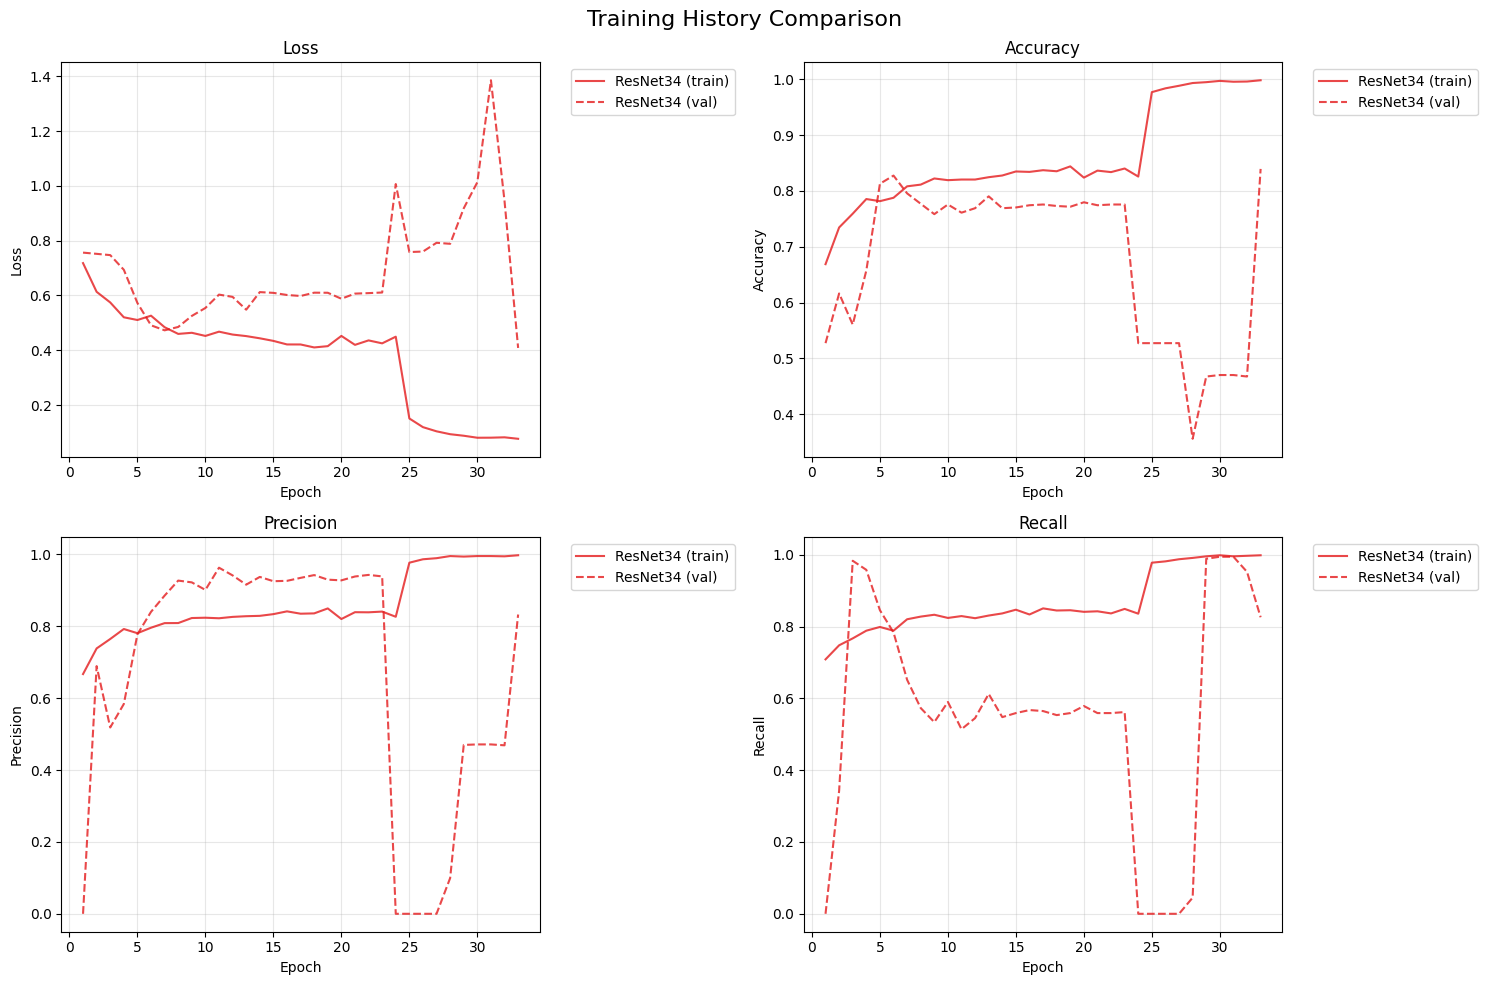


Evaluating ResNet34...
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step
Test Results for ResNet34:
  Accuracy: 0.8435
  Precision: 0.8667
  Recall: 0.8168
  F1-Score: 0.8410
  ROC AUC: 0.9103

Generating evaluation plots...


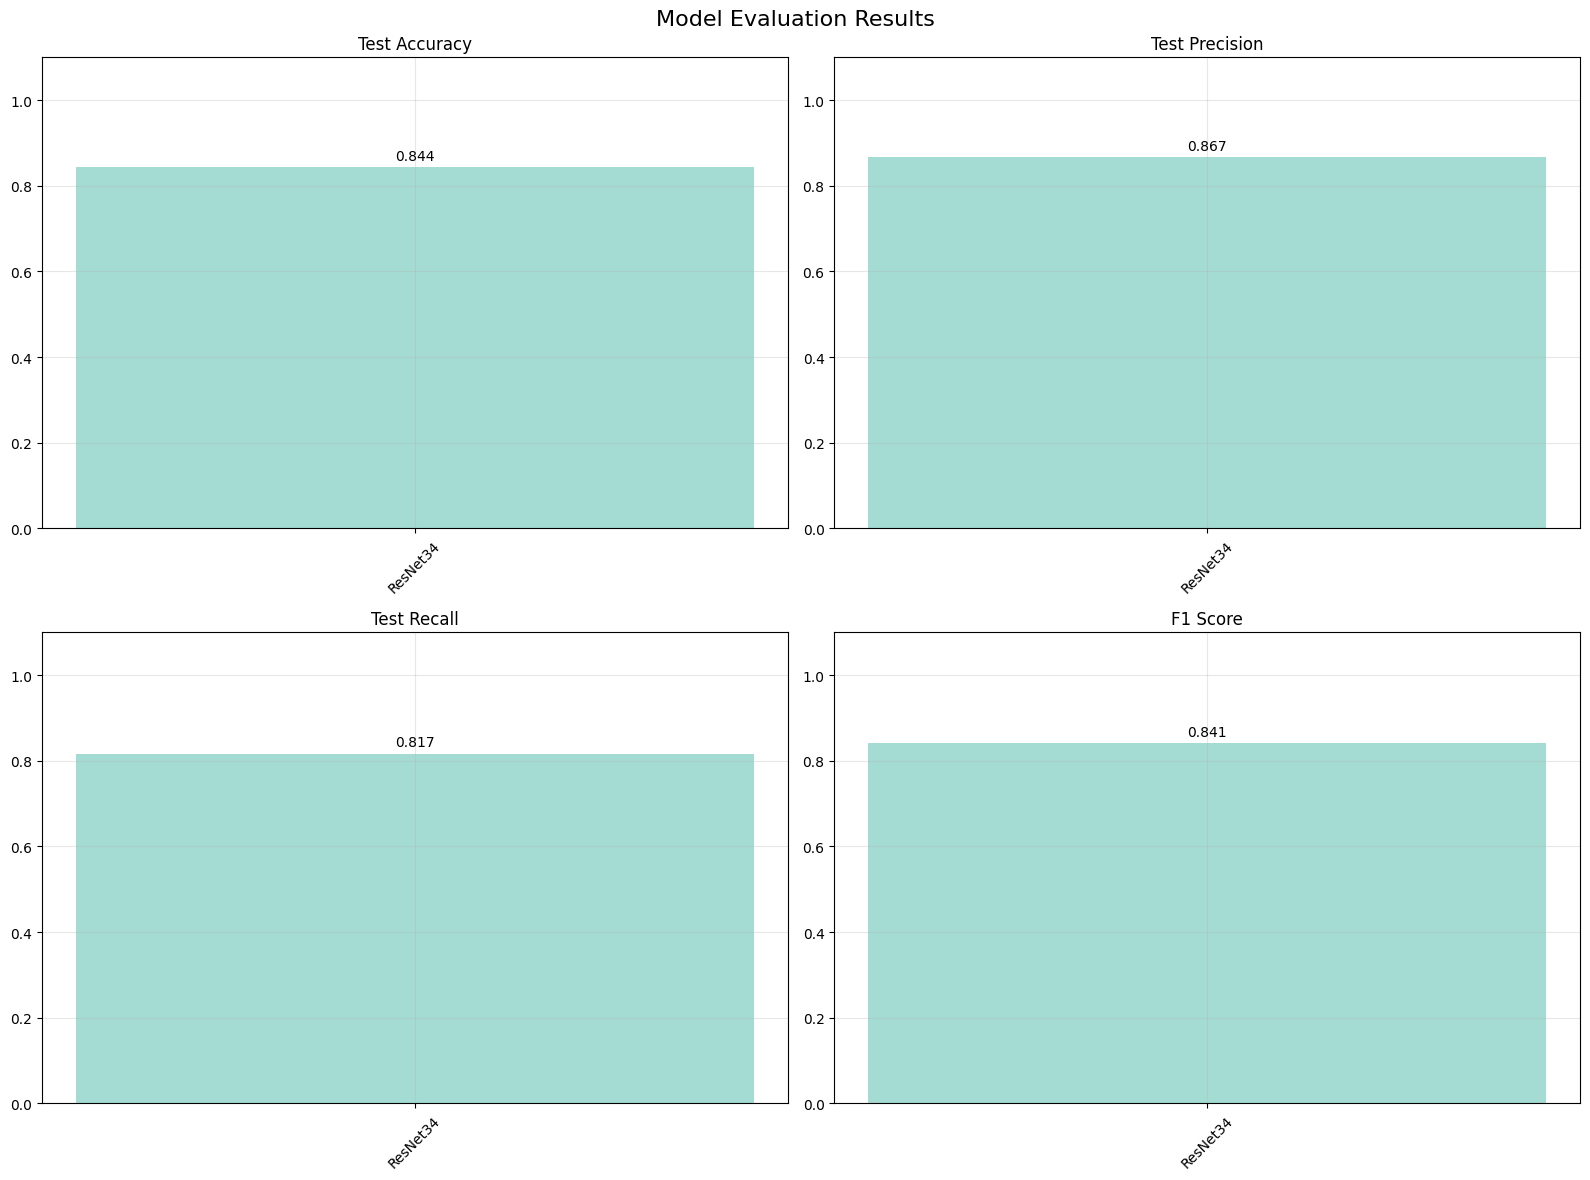

✓ Evaluation plots saved to /content/drive/MyDrive/wheat_results/model_comparison.png


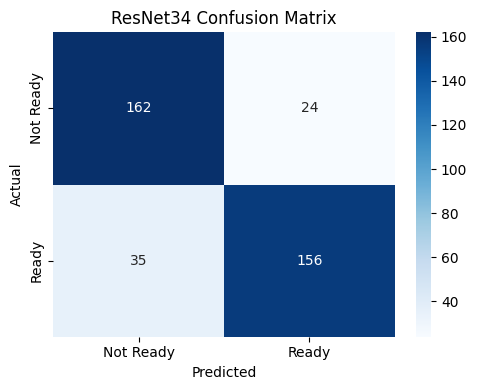

✓ Confusion matrices saved to /content/drive/MyDrive/wheat_results/confusion_matrices.png


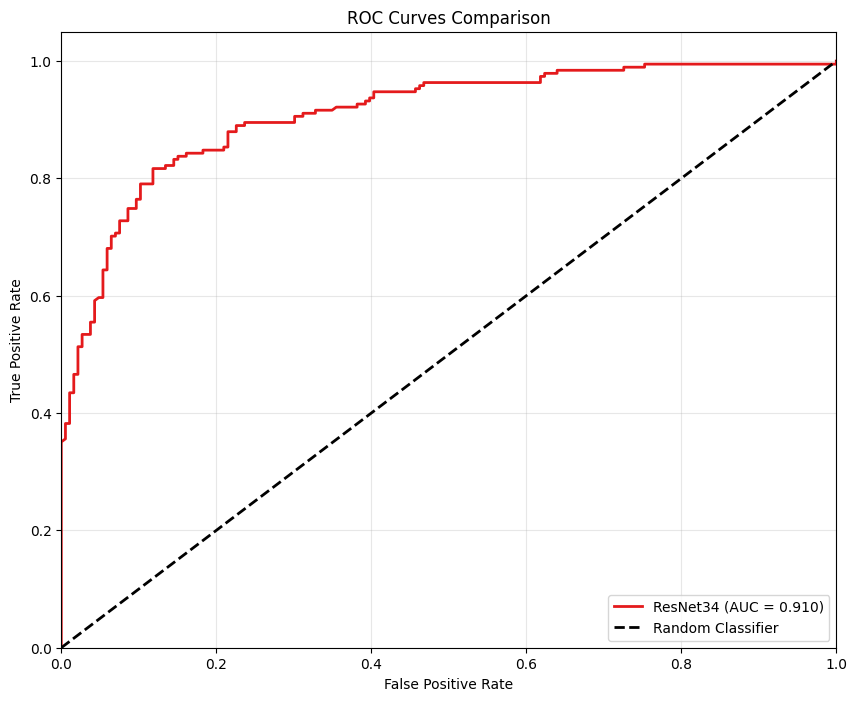

✓ ROC curves saved to /content/drive/MyDrive/wheat_results/roc_curves.png

FINAL MODEL COMPARISON SUMMARY
   Model Accuracy Precision Recall F1-Score ROC AUC
ResNet34   0.8435    0.8667 0.8168   0.8410  0.9103


In [15]:
# Plot training histories
if training_histories:
    print("Plotting training histories...")
    history_plot_path = CONFIG['results_dir'] / 'training_history.png'
    plot_training_history(training_histories, history_plot_path)

# Evaluate all trained models
evaluation_results = {}

for model_name in trained_models.keys():
    # Load best model
    model_path = CONFIG['models_dir'] / model_name / 'best_model_finetuned.h5'
    if model_path.exists():
        try:
            model = keras.models.load_model(str(model_path))
            results = evaluate_model_comprehensive(
                model, model_name, data_generators['test'], CONFIG
            )
            evaluation_results[model_name] = results

            # Save individual results
            results_file = CONFIG['results_dir'] / f'{model_name}_results.json'
            # Convert numpy arrays to lists for JSON serialization
            json_results = results.copy()
            json_results['predictions'] = results['predictions'].tolist()
            json_results['predicted_classes'] = results['predicted_classes'].tolist()
            json_results['true_labels'] = results['true_labels'].tolist()

            with open(results_file, 'w') as f:
                json.dump(json_results, f, indent=2, default=str)

        except Exception as e:
            print(f"✗ Error evaluating {model_name}: {e}")

# Generate comparison plots
if evaluation_results:
    print("\nGenerating evaluation plots...")
    plot_evaluation_results(evaluation_results, CONFIG)
    plot_confusion_matrices(evaluation_results, CONFIG)
    plot_roc_curves(evaluation_results, CONFIG)

    # Create summary table
    summary_data = []
    for model_name, results in evaluation_results.items():
        summary_data.append({
            'Model': model_name,
            'Accuracy': f"{results['test_accuracy']:.4f}",
            'Precision': f"{results['test_precision']:.4f}",
            'Recall': f"{results['test_recall']:.4f}",
            'F1-Score': f"{results['f1_score']:.4f}",
            'ROC AUC': f"{results['roc_auc']:.4f}"
        })

    summary_df = pd.DataFrame(summary_data)

    print("\n" + "="*70)
    print("FINAL MODEL COMPARISON SUMMARY")
    print("="*70)
    print(summary_df.to_string(index=False))